In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from utils import (
    auprc,
    factor_enrichment_gsea,
    get_gprofiler,
    read_aws_csv,
    read_aws_h5ad,
)

In [4]:
# read in scETM results
adata = read_aws_h5ad("s3://pert-spectra/scETM_checkpoints/scetm_inhouse/fold_0.h5ad")
# read in pertspectra results to retrieve gene labels
ref_adata = read_aws_h5ad(
    "s3://pert-spectra/PertSpectra_checkpoints/pertspectra_inhouse/fold_0.h5ad"
)
adata.var_names = ref_adata.var_names

# Reconstruction

## Spearman Coefficient
- Spearman correlation between predicted and observed expression of test set
- Compute correlation for the mean expression aggregated on perturbation, across all kfolds

In [5]:
n_folds = 5
model_adatas = []
for n in range(0, n_folds):
    # new adata
    adata_n = adata.copy()
    # load model from checkpoint
    s3_dir = "s3://pert-spectra/scETM_checkpoints/"
    experiment_name = "scetm_inhouse/"
    model_name = f"fold_{n}.h5ad"
    m_adata = read_aws_h5ad(s3_dir + experiment_name + model_name)
    model_adatas.append(m_adata)

In [6]:
# iterate through all models and get the losses and correlations
# take the mean loss and correlation for the test set
from scipy.stats import spearmanr

test_corr_singles = []
test_corr_combos = []

for n in range(n_folds):
    adata_n = model_adatas[n]
    loss_weights = np.ones(adata_n.shape[0])

    for pert in adata_n.obs["condition"].unique():
        hold_idx = [
            i
            for i, x in enumerate(
                adata_n[adata_n.obs["Treatment"] == "TNFA+"].obs["condition"]
            )
            if x == pert
        ]
        recon = adata_n[adata_n.obs["Treatment"] == "TNFA+"][hold_idx].uns["recon"]
        # correlation
        mean_reconstruction = recon.mean(axis=0)
        mean_observed = np.squeeze(
            np.array(
                adata_n[adata_n.obs["Treatment"] == "TNFA+"][hold_idx].X.mean(axis=0)
            )
        )
        if ("+" in pert) and ("ctrl" not in pert):
            test_corr_combos.append(
                [pert, spearmanr(mean_reconstruction, mean_observed)[0], n]
            )
        else:
            test_corr_singles.append(
                [pert, spearmanr(mean_reconstruction, mean_observed)[0], n]
            )

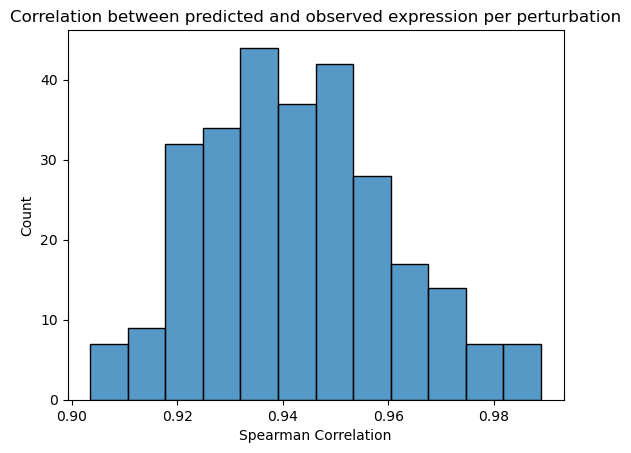

In [7]:
# plot train correlation distribution vs test correlation distribution
test_corr = np.array(test_corr_singles + test_corr_combos)[:, 1].astype(float)
sns.histplot(test_corr, label="test_corr")
plt.title("Correlation between predicted and observed expression per perturbation")
plt.xlabel("Spearman Correlation")
plt.show()

In [7]:
np.savetxt(
    "figures/reconstruction_spearmans/scETM_inhouse_spearman_correlations.csv",
    test_corr,
    delimiter=",",
    fmt="%.2f",
)

# Perturbation Embedding Heatmap

## Hierarchical Clustering + Enrichment
- Perform enrichment tests (gprofiler) on hierarchical clustering of perturbation embeddings

In [ ]:
from scipy.spatial.distance import pdist, squareform

# aggregate cell embeddings to perturbation embeddings
cell_emb = adata.uns["cell_emb"] @ adata.uns["topics"]
perts = []
pert_emb = []
for i in adata.obs["condition"].unique():
    if "+" not in i and i != "nan":
        perts.append(i)
        pert_emb.append(cell_emb[adata.obs["condition"] == i].mean(axis=0))
pert_emb = np.array(pert_emb)
pert_emb_df = pd.DataFrame(pert_emb, index=perts)

# Compute the pairwise distances
df = pert_emb_df.drop(index=["ctrl", "intergenic"])

distance = "euclidean"
distances = pdist(df.values, metric=distance)

# Convert the distances into a square distance matrix
distance_matrix = pd.DataFrame(squareform(distances), index=df.index, columns=df.index)
clustermap = sns.clustermap(distance_matrix, cmap="viridis_r")
clustermap.fig.suptitle(f"Pairwise {distance} distance of perturbation latent vectors")
# clustermap.ax_row_dendrogram.set_visible(False)
clustermap.ax_col_dendrogram.set_visible(False)
plt.show()

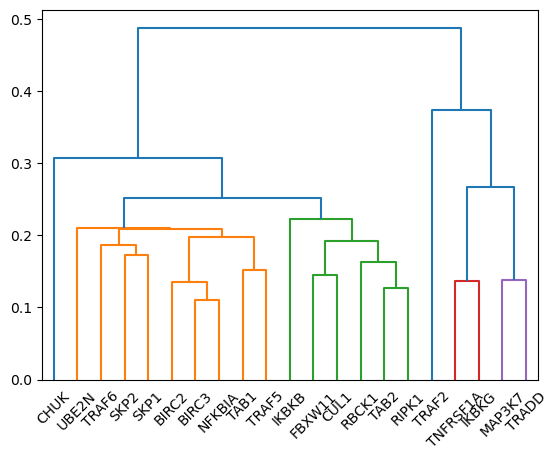

In [9]:
from scipy.cluster.hierarchy import dendrogram

den = dendrogram(
    clustermap.dendrogram_col.linkage,
    labels=distance_matrix.index,
    color_threshold=0.25,
)

In [10]:
# extract clusters and perform gprofiler
from collections import defaultdict


def get_cluster_classes(den, label="ivl"):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den["color_list"], den["icoord"]):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))
    cluster_classes = {}
    for c, l in cluster_idxs.items():  # noqa
        i_l = [den[label][i] for i in l]
        cluster_classes[c] = i_l
    return cluster_classes


clusters = get_cluster_classes(den)
# extract functions for clusters
cluster_process = {}
for c in clusters:
    cluster_df = pd.DataFrame(clusters[c], columns=["gene_symbol"])
    res = get_gprofiler(cluster_df)
    cluster_process[c] = res[res["p_value"] <= 0.05]

In [57]:
# save grpofiler results
with open(
    "figures/pert_embedding_cluster_gprofiler/scETM_inhouse_pert_emb_gprofiler.pickle",
    "wb",
) as handle:
    pickle.dump(cluster_process, handle, protocol=pickle.HIGHEST_PROTOCOL)

## PR Curve+AUC
- AUCPR using prior graph as binary label

In [11]:
aucpr_df, f1_df, pr_dict = auprc(distance_matrix)
print(aucpr_df)
print(f1_df)
aucpr_df.to_csv("figures/pert_embedding_recall/scETM_inhouse_aucpr.csv")
f1_df.to_csv("figures/pert_embedding_recall/scETM_inhouse_f1.csv")

               AUC
StringDB  0.573643
CORUM     0.520186
                F1  Threshold
StringDB  0.679641        0.0
CORUM     0.630435        0.0


# Interpretability of our learned latent space

## Factor Enrichment
- GSEA on log transformed latent-by-gene factors
- Then associate each perturbation to its top latent factors

In [ ]:
factor_to_go = factor_enrichment_gsea(adata, np.abs(adata.uns["gene_emb"]), fdr=5e-2)

2024-12-30 15:49:36,590 [INFO] Parsing data files for GSEA.............................
2024-12-30 15:49:36,656 [INFO] 17782 gene_sets have been filtered out when max_size=300 and min_size=10
2024-12-30 15:49:36,657 [INFO] 1203 gene_sets used for further statistical testing.....


In [ ]:
# filter and add description to processes
go_df = read_aws_csv("s3://pert-spectra/references/GO_to_Description.txt")
go_df.set_index("Term", inplace=True)
go_dict = go_df.to_dict()["Description"]

filtered_factor_to_go = {}
for i in factor_to_go:
    proc = factor_to_go[i]
    proc["descr"] = [go_dict[x] for x in proc["GO_ID"]]
    filtered_factor_to_go[i] = proc

In [ ]:
# save latent enrichment results
with open(
    "figures/factor_enrichments/scETM_inhouse_factor_enrichment.pickle", "wb"
) as handle:
    pickle.dump(filtered_factor_to_go, handle, protocol=pickle.HIGHEST_PROTOCOL)